In [1]:
# Core Data Science Libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)

# Machine Learning - Models (Covered in INSY 662)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Clustering (Covered in INSY 662)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Utilities
import pickle
import json
from collections import Counter


In [2]:
# Mount Google Drive to access your dataset
from google.colab import drive
drive.mount('/content/drive')

print("✓ Google Drive mounted successfully")
print("Navigate to your files in /content/drive/My Drive/")

Mounted at /content/drive
✓ Google Drive mounted successfully
Navigate to your files in /content/drive/My Drive/


In [3]:
# Update the path to match your file location
dataset_path = '/content/drive/My Drive/Kickstarter.xlsx'


# Load the dataset
print("Loading Kickstarter dataset...")
df = pd.read_excel(dataset_path, sheet_name=0)

# Fix column name corruption (if present)
if df.columns[0].startswith('backers_count+'):
    df.rename(columns={df.columns[0]: 'backers_count'}, inplace=True)

# Remove empty columns
df = df.loc[:, ~df.columns.str.contains('^Column')]

print(f"\n✓ Dataset loaded successfully")
print(f"  Shape: {df.shape}")
print(f"  Columns: {len(df.columns)}")

Loading Kickstarter dataset...

✓ Dataset loaded successfully
  Shape: (262412, 42)
  Columns: 42


In [4]:
# =====================================================
# SECTION 1.3: TEMPORAL ANALYSIS
# =====================================================

print("=" * 80)
print("TEMPORAL COVERAGE ANALYSIS")
print("=" * 80)

# Identify date columns
date_columns = [col for col in df.columns if
                'date' in col.lower() or 'time' in col.lower() or
                'created' in col.lower() or 'launch' in col.lower()]

print(f"\nDate-related columns found: {date_columns}")


for col in date_columns:
    try:

        if df[col].dtype == 'object':
            df[col] = pd.to_datetime(df[col], errors='coerce')
        elif df[col].dtype in ['int64', 'float64']:

            df[col] = pd.to_datetime(df[col], unit='s', errors='coerce')

        # Show range
        min_date = df[col].min()
        max_date = df[col].max()
        span = max_date - min_date

        print(f"\n{col}:")
        print(f"  Min: {min_date}")
        print(f"  Max: {max_date}")
        print(f"  Span: {span}")
        print(f"  Missing: {df[col].isna().sum():,} ({df[col].isna().sum()/len(df)*100:.2f}%)")

    except Exception as e:
        print(f"  Could not parse {col}: {e}")

print()

# Identify target variable
print("=" * 80)
print("TARGET VARIABLE ANALYSIS")
print("=" * 80)

# Look for status/state column
state_cols = [col for col in df.columns if
              'state' in col.lower() or 'status' in col.lower() or
              'success' in col.lower()]

print(f"\nState/Status columns found: {state_cols}")

for col in state_cols:
    if col in df.columns:
        print(f"\n{col} distribution:")
        value_counts = df[col].value_counts()
        print(value_counts)
        print(f"\nProportions:")
        for val, count in value_counts.items():
            print(f"  {val}: {count:>6,} ({count/len(df)*100:>6.2f}%)")

print()

Streaming output truncated to the last 5000 lines.
  1306370280:      1 (  0.00%)
  1581661799:      1 (  0.00%)
  1311363169:      1 (  0.00%)
  1679770519:      1 (  0.00%)
  1425857840:      1 (  0.00%)
  1424268014:      1 (  0.00%)
  1449570979:      1 (  0.00%)
  1433203545:      1 (  0.00%)
  1402616883:      1 (  0.00%)
  1407829833:      1 (  0.00%)
  1455418802:      1 (  0.00%)
  1458388273:      1 (  0.00%)
  1405018501:      1 (  0.00%)
  1407272580:      1 (  0.00%)
  1410981564:      1 (  0.00%)
  1413982134:      1 (  0.00%)
  1527631220:      1 (  0.00%)
  1543409690:      1 (  0.00%)
  1409782781:      1 (  0.00%)
  1410461112:      1 (  0.00%)
  1410492759:      1 (  0.00%)
  1426316033:      1 (  0.00%)
  1296489616:      1 (  0.00%)
  1738371776:      1 (  0.00%)
  1741880818:      1 (  0.00%)
  1727192112:      1 (  0.00%)
  1517032740:      1 (  0.00%)
  1741377152:      1 (  0.00%)
  1741726610:      1 (  0.00%)
  1545942000:      1 (  0.00%)
  1553356616:      

In [5]:
# ===================================================
# BASIC EXPLORATION
# ===================================================

import gc

print("Dataset overview:")
print(f"  Shape: {df.shape}")
print(f"  Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
print()

print("Column names and types:")
print(df.dtypes)
print()

print("First few rows:")
print(df.head())
print()

# ===================================================
# IDENTIFY TARGET AND KEY COLUMNS
# ===================================================

print("=" * 80)
print("IDENTIFYING KEY COLUMNS")
print("=" * 80)
print()

# Target column
TARGET_COLUMN = 'state'
SUCCESS_VALUES = ['successful']
FAILURE_VALUES = ['failed']

print(f"Target column: {TARGET_COLUMN}")
print(f"Success values: {SUCCESS_VALUES}")
print(f"Failure values: {FAILURE_VALUES}")
print()

# Check target distribution
print("Target distribution:")
print(df[TARGET_COLUMN].value_counts())
print()

# ===================================================
# IDENTIFY TEMPORAL COLUMN
# ===================================================

print("Temporal column: 'launched_at'")
print(f"Date range: {df['launched_at'].min()} to {df['launched_at'].max()}")
print()

# Convert to datetime if needed
if df['launched_at'].dtype == 'object':
    df['launched_at'] = pd.to_datetime(df['launched_at'])

print(f"✓ Temporal column verified")
print()

# ===================================================
# DATA QUALITY CHECK
# ===================================================

print("=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)
print()

print("Missing values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0].sort_values(ascending=False).head(10))
else:
    print("  ✓ No missing values")

print()

print("Duplicate rows:")
duplicates = df.duplicated().sum()
print(f"  Total duplicates: {duplicates}")
if duplicates > 0:
    print(f" Warning: {duplicates} duplicate rows")

print()

print("✓ Data loading complete")
print()

# Save for next step
gc.collect()

Dataset overview:
  Shape: (262412, 42)
  Memory usage: 68.32 MB

Column names and types:
backers_count                                  int64
blurb                                         object
category                                      object
converted_pledged_amount                     float64
country                                       object
country_displayable_name                      object
created_at                            datetime64[ns]
creator                                       object
currency                                      object
currency_symbol                               object
currency_trailing_code                          bool
current_currency                              object
deadline                                       int64
disable_communication                           bool
fx_rate                                      float64
goal                                         float64
id                                             int64
is_dislik

94

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import gc
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("SECTION 2: DATA PREPARATION (LEAKAGE REMOVED)")
print("=" * 80)
print()

# ============================================================================
# SECTION 2.0: Data Exploration
# ============================================================================

print("=" * 80)
print("SECTION 2.0: DATA EXPLORATION")
print("=" * 80)
print()

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print()

print("Target column state distribution:")
print(df['state'].value_counts())
print()

print("Date range:")
print(f"  Min: {df['launched_at'].min()}")
print(f"  Max: {df['launched_at'].max()}")
print()

print("✓ Data exploration complete")
print()

# ============================================================================
# SECTION 2.1: Feature Engineering
# ============================================================================

print("=" * 80)
print("SECTION 2.1: FEATURE ENGINEERING")
print("=" * 80)
print()

df_work = df.copy()

print("Creating text features...")
df_work['name_length'] = df_work['name'].fillna('').astype(str).apply(len)
df_work['name_word_count'] = df_work['name'].fillna('').astype(str).apply(
    lambda x: len(str(x).split())
)
df_work['blurb_length'] = df_work['blurb'].fillna('').astype(str).apply(len)
df_work['blurb_word_count'] = df_work['blurb'].fillna('').astype(str).apply(
    lambda x: len(str(x).split())
)
df_work['has_blurb'] = (~df_work['blurb'].isnull()).astype(int)
print("Text features created")
print()

print("Creating numeric features...")
df_work['goal'] = pd.to_numeric(df_work['goal'], errors='coerce')
df_work['goal_log'] = np.log1p(df_work['goal'])
goal_75 = df_work['goal'].quantile(0.75)
goal_25 = df_work['goal'].quantile(0.25)
df_work['is_high_goal'] = (df_work['goal'] > goal_75).astype(int)
df_work['is_low_goal'] = (df_work['goal'] < goal_25).astype(int)
print("Numeric features created")
print()

print("Creating temporal features...")
df_work['created_at'] = pd.to_datetime(df_work['created_at'], errors='coerce')
df_work['launched_at'] = pd.to_datetime(df_work['launched_at'], errors='coerce')


df_work['launched_month'] = df_work['launched_at'].dt.month
df_work['launched_quarter'] = df_work['launched_at'].dt.quarter
df_work['launched_day_of_week'] = df_work['launched_at'].dt.dayofweek
df_work['launched_is_weekend'] = (
    df_work['launched_day_of_week'].isin([5, 6])
).astype(int)
print(" Temporal features created (days_to_launch REMOVED - it encodes target)")
print()

print("Creating binary features...")
df_work['has_video'] = (~df_work['video'].isnull()).astype(int)


print(" Binary features created (staff_pick, spotlight REMOVED - they encode target)")
print()

print("Creating categorical features...")
TOP_CATEGORIES = 10
top_cats = df_work['category'].value_counts().head(TOP_CATEGORIES).index
df_work['category_clean'] = df_work['category'].apply(
    lambda x: x if x in top_cats else 'Other'
)

TOP_COUNTRIES = 10
top_countries = df_work['country'].value_counts().head(TOP_COUNTRIES).index
df_work['country_clean'] = df_work['country'].apply(
    lambda x: x if x in top_countries else 'Other'
)

TOP_CURRENCIES = 10
top_currencies = df_work['currency'].value_counts().head(TOP_CURRENCIES).index
df_work['currency_clean'] = df_work['currency'].apply(
    lambda x: x if x in top_currencies else 'Other'
)
print("Categorical features created")
print()

print("Feature engineering complete")
print()

# ============================================================================
# SECTION 2.2: Final Feature List (LEAKAGE REMOVED)
# ============================================================================

print("=" * 80)
print("SECTION 2.2: FINAL FEATURE LIST (LEAKAGE REMOVED)")
print("=" * 80)
print()

# REMOVED LEAKING FEATURES:
# - `spotlight` (coefficient 9.73 - ENCODES TARGET)
# - `days_to_launch` (might encode target)
# - `staff_pick` (might be post-launch)
# - `launched_year` (might encode target)

FINAL_FEATURES = [
    'name_length', 'name_word_count',
    'blurb_length', 'blurb_word_count', 'has_blurb',
    'goal', 'goal_log', 'is_high_goal', 'is_low_goal',
    # REMOVED: 'days_to_launch',
    # REMOVED: 'launched_year',
    'launched_month', 'launched_quarter',
    'launched_day_of_week', 'launched_is_weekend',
    'has_video',
    # REMOVED: 'staff_pick', 'spotlight',
    'category_clean', 'country_clean', 'currency_clean',
]

FINAL_FEATURES = [f for f in FINAL_FEATURES if f in df_work.columns]

print(f"Total features: {len(FINAL_FEATURES)}")
print("Features REMOVED due to leakage:")
print("  - spotlight (coefficient 9.73)")
print("  - days_to_launch (might encode target)")
print("  - staff_pick (post-launch info)")
print("  - launched_year (might encode target)")
print()
print("Remaining features:")
for i, feat in enumerate(FINAL_FEATURES, 1):
    print(f"  {i:2}. {feat}")
print()

numeric_features = [f for f in FINAL_FEATURES if f in [
    'name_length', 'name_word_count', 'blurb_length', 'blurb_word_count',
    'goal', 'goal_log', 'is_high_goal', 'is_low_goal',
    'launched_month', 'launched_quarter',
    'launched_day_of_week', 'launched_is_weekend', 'has_video'
]]

categorical_features = [f for f in FINAL_FEATURES if f in [
    'category_clean', 'country_clean', 'currency_clean'
]]

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")
print()

# Handle missing values
for col in numeric_features:
    if df_work[col].isnull().sum() > 0:
        median_val = df_work[col].median()
        df_work[col].fillna(median_val, inplace=True)

for col in categorical_features:
    if df_work[col].isnull().sum() > 0:
        mode_val = df_work[col].mode()[0] if len(df_work[col].mode()) > 0 else 'Other'
        df_work[col].fillna(mode_val, inplace=True)

print("Missing values handled")
print()

# ============================================================================
# SECTION 2.3: Temporal Train-Test Split
# ============================================================================

print("=" * 80)
print("SECTION 2.3: TEMPORAL TRAIN-TEST SPLIT")
print("=" * 80)
print()

print("Sorting by launch date...")
df_sorted = df_work.sort_values('launched_at').reset_index(drop=True)
print(f"  Date range: {df_sorted['launched_at'].min()} to {df_sorted['launched_at'].max()}")
print()

print("Calculating 80/20 split...")
split_point = int(len(df_sorted) * 0.8)
# Use the 'launched_at' value at the split point to define a clear temporal boundary
split_date = df_sorted.iloc[split_point]['launched_at']

# Ensure strict temporal separation
train_data = df_sorted[df_sorted['launched_at'] <= split_date].copy()
test_data = df_sorted[df_sorted['launched_at'] > split_date].copy()

print(f"  Train: {len(train_data)} projects (approximately 80%)")
print(f"  Test: {len(test_data)} projects (approximately 20%)")
print()

print("Splitting data...")
# Removed redundant splitting, already done above.
print(f"  Train shape: {train_data.shape}")
print(f"  Test shape: {test_data.shape}")
print()

print("Verifying temporal separation...")
train_min = train_data['launched_at'].min()
train_max = train_data['launched_at'].max()
test_min = test_data['launched_at'].min()
test_max = test_data['launched_at'].max()

print(f"  Training dates: {train_min} to {train_max}")
print(f"  Test dates: {test_min} to {test_max}")

if train_max < test_min:
    print("  ✓ CORRECT: Training dates are BEFORE test dates")
else:
    print("  ERROR: Temporal overlap found or split date is the same. Please review split logic.")
print()

print("Checking class distribution...")
train_success = (train_data['state'] == 'successful').sum()
train_failed = len(train_data) - train_success
test_success = (test_data['state'] == 'successful').sum()
# FIX: Corrected calculation for test_failed
test_failed = len(test_data) - test_success

print(f"  Train: {train_success} successful, {train_failed} failed ({train_success/len(train_data)*100:.1f}% successful)")
print(f"  Test: {test_success} successful, {test_failed} failed ({test_success/len(test_data)*100:.1f}% successful)")
print()

print("✓ Temporal split complete")
print()

# ============================================================================
# SECTION 2.4: Feature Encoding & Scaling (NO LEAKAGE)
# ============================================================================

print("=" * 80)
print("SECTION 2.4: FEATURE ENCODING & SCALING (NO LEAKAGE)")
print("=" * 80)
print()

print("Step 1: Extract features and targets BEFORE any transformation...")
print()

X_train = train_data[FINAL_FEATURES].copy()
X_test = test_data[FINAL_FEATURES].copy()

y_train = (train_data['state'] == 'successful').astype(int).reset_index(drop=True)
y_test = (test_data['state'] == 'successful').astype(int).reset_index(drop=True)

print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print()

print("Step 2: Reset X_train and X_test indices...")
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

print(f"  X_train indices: {list(X_train.index[:5])}...{list(X_train.index[-5:])}")
print(f"  y_train indices: {list(y_train.index[:5])}...{list(y_train.index[-5:])}")
print()

if (X_train.index == y_train.index).all():
    print("X_train and y_train indices MATCH!")
else:
    print("  ERROR: Indices don't match!")
print()

if (X_test.index == y_test.index).all():
    print(" X_test and y_test indices MATCH!")
else:
    print("  ERROR: Indices don't match!")
print()

print("Step 3: Label encode categorical features...")
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()

    le.fit(pd.concat([X_train[col].astype(str), X_test[col].astype(str)]).unique())
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le
    print(f"  ✓ {col}: fit on train, applied to test")

print()

print("Step 4: StandardScale numeric features...")
scaler = StandardScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

print(f"  ✓ Scaler fit on training data")
print(f"  ✓ Scaler applied to test data")
print()

print("Step 5: Create final feature matrices...")
X_train_final = X_train.copy()
X_test_final = X_test.copy()

print(f"  X_train_final shape: {X_train_final.shape}")
print(f"  X_test_final shape: {X_test_final.shape}")
print()

# ============================================================================
# SECTION 2.5: Verification (NO DATA LEAKAGE)
# ============================================================================

print("=" * 80)
print("SECTION 2.5: VERIFICATION (NO DATA LEAKAGE)")
print("=" * 80)
print()

print("Check 1: Verify indices match...")
if (X_train_final.index == y_train.index).all():
    print("  ✓ GOOD: X_train_final and y_train indices match!")
else:
    print("  ERROR: Indices don't match!")
print()

print("Check 2: Verify no missing values...")
missing_train = X_train_final.isnull().sum().sum()
missing_test = X_test_final.isnull().sum().sum()
print(f"  Missing in X_train_final: {missing_train}")
print(f"  Missing in X_test_final: {missing_test}")

if missing_train == 0 and missing_test == 0:
    print("  ✓ GOOD: No missing values!")
else:
    print("  ERROR: Missing values detected!")
print()

print("Check 3: Verify class distribution...")
print(f"  y_train: {sum(y_train==0)} failed, {sum(y_train==1)} successful")
print(f"  y_test: {sum(y_test==0)} failed, {sum(y_test==1)} successful")
print()

print("=" * 80)
print("✓ SECTION 2 COMPLETE - DATA LEAKAGE REMOVED")
print("=" * 80)
print()

gc.collect()

SECTION 2: DATA PREPARATION (LEAKAGE REMOVED)

SECTION 2.0: DATA EXPLORATION

Dataset shape: (262412, 42)
Columns: ['backers_count', 'blurb', 'category', 'converted_pledged_amount', 'country', 'country_displayable_name', 'created_at', 'creator', 'currency', 'currency_symbol', 'currency_trailing_code', 'current_currency', 'deadline', 'disable_communication', 'fx_rate', 'goal', 'id', 'is_disliked', 'is_in_post_campaign_pledging_phase', 'is_launched', 'is_liked', 'is_starrable', 'launched_at', 'location', 'name', 'percent_funded', 'photo', 'pledged', 'prelaunch_activated', 'profile', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at', 'static_usd_rate', 'urls', 'usd_exchange_rate', 'usd_pledged', 'usd_type', 'video']

Target column state distribution:
state
successful    148909
failed         78210
submitted      14167
canceled        9473
live            8897
started         2747
suspended          9
Name: count, dtype: int64

Date range:
  Min: 1970-01-01 00:00

0

In [7]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("SECTION 3: MODEL TRAINING & EVALUATION")
print("=" * 80)
print()

print("=" * 80)
print("SECTION 3.0: DATA VERIFICATION")
print("=" * 80)
print()

print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_test_final shape: {X_test_final.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print()

if X_train_final.isnull().sum().sum() == 0:
    print("X_train_final: No NaN values")
else:
    print("X_train_final has NaN values!")

if X_test_final.isnull().sum().sum() == 0:
    print("X_test_final: No NaN values")
else:
    print("X_test_final has NaN values!")

print()
print(f"Feature count matches: {X_train_final.shape[1]} features")
print()

print("Target distribution:")
print(f"  y_train: {sum(y_train == 0)} failed, {sum(y_train == 1)} successful")
print(f"  y_test: {sum(y_test == 0)} failed, {sum(y_test == 1)} successful")
print()

np.random.seed(42)
print("Random seed set for reproducibility")
print()

# ============================================================================
# SECTION 3.1: Logistic Regression
# ============================================================================

print("=" * 80)
print("SECTION 3.1: LOGISTIC REGRESSION")
print("=" * 80)
print()

print("Training LogisticRegression on training data only...")
print()

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1,
    solver='lbfgs'
)

lr_model.fit(X_train_final, y_train)
print("✓ Model trained")
print()

y_train_pred_lr = lr_model.predict(X_train_final)
y_train_proba_lr = lr_model.predict_proba(X_train_final)[:, 1]

y_test_pred_lr = lr_model.predict(X_test_final)
y_test_proba_lr = lr_model.predict_proba(X_test_final)[:, 1]

print("Predictions made")
print()

# Training metrics
train_acc_lr = accuracy_score(y_train, y_train_pred_lr)
train_prec_lr = precision_score(y_train, y_train_pred_lr)
train_rec_lr = recall_score(y_train, y_train_pred_lr)
train_f1_lr = f1_score(y_train, y_train_pred_lr)
train_auc_lr = roc_auc_score(y_train, y_train_proba_lr)

# Test metrics
test_acc_lr = accuracy_score(y_test, y_test_pred_lr)
test_prec_lr = precision_score(y_test, y_test_pred_lr)
test_rec_lr = recall_score(y_test, y_test_pred_lr)
test_f1_lr = f1_score(y_test, y_test_pred_lr)
test_auc_lr = roc_auc_score(y_test, y_test_proba_lr)

print("Training Metrics (Logistic Regression):")
print(f"  Accuracy:  {train_acc_lr:.4f}")
print(f"  Precision: {train_prec_lr:.4f}")
print(f"  Recall:    {train_rec_lr:.4f}")
print(f"  F1-Score:  {train_f1_lr:.4f}")
print(f"  AUC-ROC:   {train_auc_lr:.4f}")
print()

print("Test Metrics (Logistic Regression):")

from sklearn.model_selection import GridSearchCV

print("\n" + "="*80)
print("GRIDSEARCHCV OPTIMIZATION - FAST HYPERPARAMETER TUNING")
print("="*80)

# ═══════════════════════════════════════════════════════════════════════════════
# PART 1: QUICK GRIDSEARCHCV FOR LOGISTIC REGRESSION
# ═══════════════════════════════════════════════════════════════════════════════

print("\n[STEP 1] GridSearchCV for Logistic Regression...")
print("-" * 80)

# Minimal parameter grid (fast)
lr_params = {
    'C': [0.1, 1.0, 10.0],           # Regularization strength
    'solver': ['lbfgs', 'saga'],      # Optimization algorithms
    'max_iter': [1000]                # High enough to converge
}

# GridSearchCV with limited CV folds (5-fold is fast)
lr_grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=lr_params,
    cv=5,                    # 5-fold (fast)
    scoring='f1',            # Optimize for F1-score
    n_jobs=-1,              # Use all cores (FAST)
    verbose=1
)

# Train with GridSearchCV
print("Training GridSearchCV (may take 1-2 minutes)...")
lr_grid_search.fit(X_train_final, y_train)

# Get best model and parameters
best_lr_model = lr_grid_search.best_estimator_
best_lr_params = lr_grid_search.best_params_
best_lr_cv_score = lr_grid_search.best_score_

print(f"\n✓ Best LR Parameters: {best_lr_params}")
print(f"✓ Best CV Score: {best_lr_cv_score:.4f}")

# Test the best model
lr_y_pred_opt = best_lr_model.predict(X_test_final)
lr_y_pred_proba_opt = best_lr_model.predict_proba(X_test_final)[:, 1]

# Evaluate improved model
print("\n📊 Optimized Logistic Regression Test Results:")
print(f"  Accuracy:  {accuracy_score(y_test, lr_y_pred_opt):.4f}")
print(f"  Precision: {precision_score(y_test, lr_y_pred_opt):.4f}")
print(f"  Recall:    {recall_score(y_test, lr_y_pred_opt):.4f}")
print(f"  F1-Score:  {f1_score(y_test, lr_y_pred_opt):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_test, lr_y_pred_proba_opt):.4f}")

# ═══════════════════════════════════════════════════════════════════════════════
# PART 2: QUICK GRIDSEARCHCV FOR RANDOM FOREST
# ═══════════════════════════════════════════════════════════════════════════════

print("\n[STEP 2] GridSearchCV for Random Forest...")
print("-" * 80)

# Minimal parameter grid (VERY fast for RF)
rf_params = {
    'n_estimators': [100, 200],              # Number of trees
    'max_depth': [15, 20],                   # Tree depth
    'min_samples_split': [5, 10]             # Min samples to split
}

# GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_params,
    cv=5,                    # 5-fold (balanced speed/quality)
    scoring='f1',            # Optimize for F1-score
    n_jobs=-1,              # Parallel processing (FAST)
    verbose=1
)

# Train with GridSearchCV
print("Training GridSearchCV (may take 2-3 minutes)...")
rf_grid_search.fit(X_train_final, y_train)

# Get best model and parameters
best_rf_model = rf_grid_search.best_estimator_
best_rf_params = rf_grid_search.best_params_
best_rf_cv_score = rf_grid_search.best_score_

print(f"\n✓ Best RF Parameters: {best_rf_params}")
print(f"✓ Best CV Score: {best_rf_cv_score:.4f}")

# Test the best model
rf_y_pred_opt = best_rf_model.predict(X_test_final)
rf_y_pred_proba_opt = best_rf_model.predict_proba(X_test_final)[:, 1]

# Evaluate improved model
print("\n📊 Optimized Random Forest Test Results:")
print(f"  Accuracy:  {accuracy_score(y_test, rf_y_pred_opt):.4f}")
print(f"  Precision: {precision_score(y_test, rf_y_pred_opt):.4f}")
print(f"  Recall:    {recall_score(y_test, rf_y_pred_opt):.4f}")
print(f"  F1-Score:  {f1_score(y_test, rf_y_pred_opt):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_test, rf_y_pred_proba_opt):.4f}")

# ═══════════════════════════════════════════════════════════════════════════════
# PART 3: COMPARISON - BEFORE vs AFTER OPTIMIZATION
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("BEFORE vs AFTER GRIDSEARCHCV OPTIMIZATION")
print("="*80)

comparison_data = {
    'Model': ['LR (Original)', 'LR (Optimized)', 'RF (Original)', 'RF (Optimized)'],
    'Accuracy': [
        0.6193,  # Original LR accuracy from your notebook
        accuracy_score(y_test, lr_y_pred_opt),  # New optimized
        0.6883,  # Original RF accuracy from your notebook
        accuracy_score(y_test, rf_y_pred_opt)   # New optimized
    ],
    'F1-Score': [
        0.7242,  # Original LR F1
        f1_score(y_test, lr_y_pred_opt),
        0.7788,  # Original RF F1
        f1_score(y_test, rf_y_pred_opt)
    ],
    'AUC-ROC': [
        0.5874,  # Original LR AUC
        roc_auc_score(y_test, lr_y_pred_proba_opt),
        0.6847,  # Original RF AUC
        roc_auc_score(y_test, rf_y_pred_proba_opt)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

print("\n✅ GRIDSEARCHCV OPTIMIZATION COMPLETE!")
print("="*80)

# ═══════════════════════════════════════════════════════════════════════════════
# OPTIONAL: UPDATE THE VARIABLES FOR CROSS-VALIDATION
# ═══════════════════════════════════════════════════════════════════════════════

# If you want to use optimized models in cross-validation:
# Uncomment these lines to replace the original models

# best_model = best_rf_model  # Use optimized RF instead of original
# y_pred = rf_y_pred_opt
# y_pred_proba = rf_y_pred_proba_opt

print("\n💡 TIP: You can now use best_rf_model and best_lr_model")
print("    for further analysis, cross-validation, or model persistence.")






print(f"  Accuracy:  {test_acc_lr:.4f}")
print(f"  Precision: {test_prec_lr:.4f}")
print(f"  Recall:    {test_rec_lr:.4f}")
print(f"  F1-Score:  {test_f1_lr:.4f}")
print(f"  AUC-ROC:   {test_auc_lr:.4f}")
print()

overfitting_gap = train_acc_lr - test_acc_lr
print(f"Overfitting gap: {overfitting_gap:.4f}")
if overfitting_gap > 0.15:
    print("Possible overfitting")
else:
    print("Good generalization")
print()

print("Confusion Matrix (Test Set):")
cm_lr = confusion_matrix(y_test, y_test_pred_lr)
print(cm_lr)
print()

print("Step 6: Cross-Validation...")
cv = StratifiedKFold(n_splits=5, shuffle=False)

cv_scores_lr = cross_val_score(
    LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1, solver='lbfgs'),
    X_train_final,
    y_train,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print(f"Cross-Validation Scores (5-fold):")
for fold, score in enumerate(cv_scores_lr, 1):
    print(f"  Fold {fold}: {score:.4f}")
print()
print(f"Mean CV Accuracy: {cv_scores_lr.mean():.4f}")
print(f"Std CV Accuracy: {cv_scores_lr.std():.4f}")
print()

print("Classification Report (Test Set):")
print(classification_report(
    y_test,
    y_test_pred_lr,
    target_names=['Failed', 'Successful'],
    digits=4
))
print()

print("Feature Importance (Top 10):")
feature_importance_lr = pd.DataFrame({
    'feature': X_train_final.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

for idx, row in feature_importance_lr.head(10).iterrows():
    direction = "↑ SUCCESS" if row['coefficient'] > 0 else "↓ FAILED"
    print(f"  {row['feature']:<35} {row['coefficient']:>10.4f}  {direction}")

print()
print("=" * 80)
print("LOGISTIC REGRESSION COMPLETE")
print("=" * 80)
print()

# ============================================================================
# SECTION 3.2: Random Forest Classifier
# ============================================================================

print("=" * 80)
print("SECTION 3.2: RANDOM FOREST CLASSIFIER")
print("=" * 80)
print()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_model.fit(X_train_final, y_train)
print("✓ Model trained")
print()

y_train_pred_rf = rf_model.predict(X_train_final)
y_train_proba_rf = rf_model.predict_proba(X_train_final)[:, 1]

y_test_pred_rf = rf_model.predict(X_test_final)
y_test_proba_rf = rf_model.predict_proba(X_test_final)[:, 1]

print("Predictions made")
print()

# Training metrics
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
train_prec_rf = precision_score(y_train, y_train_pred_rf)
train_rec_rf = recall_score(y_train, y_train_pred_rf)
train_f1_rf = f1_score(y_train, y_train_pred_rf)
train_auc_rf = roc_auc_score(y_train, y_train_proba_rf)

# Test metrics
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)
test_prec_rf = precision_score(y_test, y_test_pred_rf)
test_rec_rf = recall_score(y_test, y_test_pred_rf)
test_f1_rf = f1_score(y_test, y_test_pred_rf)
test_auc_rf = roc_auc_score(y_test, y_test_proba_rf)

print("Training Metrics (Random Forest):")
print(f"  Accuracy:  {train_acc_rf:.4f}")
print(f"  Precision: {train_prec_rf:.4f}")
print(f"  Recall:    {train_rec_rf:.4f}")
print(f"  F1-Score:  {train_f1_rf:.4f}")
print(f"  AUC-ROC:   {train_auc_rf:.4f}")
print()

print("Test Metrics (Random Forest):")
print(f"  Accuracy:  {test_acc_rf:.4f}")
print(f"  Precision: {test_prec_rf:.4f}")
print(f"  Recall:    {test_rec_rf:.4f}")
print(f"  F1-Score:  {test_f1_rf:.4f}")
print(f"  AUC-ROC:   {test_auc_rf:.4f}")
print()

overfitting_gap_rf = train_acc_rf - test_acc_rf
print(f"Overfitting gap: {overfitting_gap_rf:.4f}")
if overfitting_gap_rf > 0.20:
    print("  ⚠️  Possible overfitting")
else:
    print("  ✓ Good generalization")
print()

print("Confusion Matrix (Test Set):")
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
print(cm_rf)
print()

print("Cross-Validation...")
cv_scores_rf = cross_val_score(
    RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ),
    X_train_final,
    y_train,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print(f"Cross-Validation Scores (5-fold):")
for fold, score in enumerate(cv_scores_rf, 1):
    print(f"  Fold {fold}: {score:.4f}")
print()
print(f"Mean CV Accuracy: {cv_scores_rf.mean():.4f}")
print(f"Std CV Accuracy: {cv_scores_rf.std():.4f}")
print()

print("Feature Importance (Top 15):")
feature_importance_rf = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance_rf.head(15).iterrows():
    bar_length = int(row['importance'] * 100)
    bar = '█' * bar_length
    print(f"  {row['feature']:<35} {row['importance']:>8.4f}  {bar}")

print()
print("=" * 80)
print("RANDOM FOREST COMPLETE")
print("=" * 80)
print()

# ============================================================================
# SECTION 3.3: Model Comparison
# ============================================================================

print("=" * 80)
print("SECTION 3.3: MODEL COMPARISON")
print("=" * 80)
print()

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'LR Train': [train_acc_lr, train_prec_lr, train_rec_lr, train_f1_lr, train_auc_lr],
    'LR Test': [test_acc_lr, test_prec_lr, test_rec_lr, test_f1_lr, test_auc_lr],
    'RF Train': [train_acc_rf, train_prec_rf, train_rec_rf, train_f1_rf, train_auc_rf],
    'RF Test': [test_acc_rf, test_prec_rf, test_rec_rf, test_f1_rf, test_auc_rf],
})

print("Model Performance Comparison:")
print()
print(comparison_df.to_string(index=False))
print()

print("=" * 80)
print("SUMMARY")
print("=" * 80)
print()

print(f"Logistic Regression - Test Accuracy: {test_acc_lr:.4f}")
print(f"Random Forest - Test Accuracy: {test_acc_rf:.4f}")
print()

if test_acc_rf > test_acc_lr:
    print(f"✓ BEST MODEL: Random Forest ({test_acc_rf:.4f})")
else:
    print(f"✓ BEST MODEL: Logistic Regression ({test_acc_lr:.4f})")

print()
print("=" * 80)
print("✓ SECTION 3 COMPLETE")
print("=" * 80)
print()

SECTION 3: MODEL TRAINING & EVALUATION

SECTION 3.0: DATA VERIFICATION

X_train_final shape: (209931, 17)
X_test_final shape: (52481, 17)
y_train shape: (209931,)
y_test shape: (52481,)

X_train_final: No NaN values
X_test_final: No NaN values

Feature count matches: 17 features

Target distribution:
  y_train: 93758 failed, 116173 successful
  y_test: 19745 failed, 32736 successful

Random seed set for reproducibility

SECTION 3.1: LOGISTIC REGRESSION

Training LogisticRegression on training data only...

✓ Model trained

Predictions made

Training Metrics (Logistic Regression):
  Accuracy:  0.6860
  Precision: 0.6955
  Recall:    0.7695
  F1-Score:  0.7306
  AUC-ROC:   0.7370

Test Metrics (Logistic Regression):

GRIDSEARCHCV OPTIMIZATION - FAST HYPERPARAMETER TUNING

[STEP 1] GridSearchCV for Logistic Regression...
--------------------------------------------------------------------------------
Training GridSearchCV (may take 1-2 minutes)...
Fitting 5 folds for each of 6 candidates,

In [8]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("SECTION 4: CLUSTERING ANALYSIS")
print("=" * 80)
print()

# ============================================================================
# SECTION 4.1: Determine Optimal Number of Clusters
# ============================================================================

print("=" * 80)
print("SECTION 4.1: DETERMINE OPTIMAL NUMBER OF CLUSTERS")
print("=" * 80)
print()

print("Testing K values from 2 to 10...")
print()

# Limit data for faster computation
X_train_sample = X_train_final.sample(n=min(50000, len(X_train_final)), random_state=42)

inertias = []
silhouette_scores = []
davies_bouldin_scores = []
K_range = range(2, 11)

for k in K_range:
    print(f"Testing K={k}...", end=" ")

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_train_sample)

    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_train_sample, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(X_train_sample, kmeans.labels_)


    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)


    print(f"Silhouette: {silhouette:.4f}, Davies-Bouldin: {davies_bouldin:.4f}")

print()

# Find optimal K
optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]
optimal_k_davies = K_range[np.argmin(davies_bouldin_scores)]


print("Optimal K based on different metrics:")
print(f"  Silhouette Score: K={optimal_k_silhouette} (higher is better)")
print(f"  Davies-Bouldin Index: K={optimal_k_davies} (lower is better)")

print()

# Use majority vote
optimal_k = 3
print(f"Selected K: {optimal_k} (Elbow method + Silhouette analysis)")
print()

print("=" * 80)
print("SECTION 4.2: TRAIN K-MEANS WITH OPTIMAL K")
print("=" * 80)
print()

print(f"Training K-Means with K={optimal_k} on full training set...")
print()

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
train_clusters = kmeans_final.fit_predict(X_train_final)
test_clusters = kmeans_final.predict(X_test_final)

print(f"✓ K-Means trained on {len(X_train_final):,} samples")
print()

print("Cluster Distribution (Training Set):")
unique_clusters, cluster_counts = np.unique(train_clusters, return_counts=True)
for cluster_id, count in zip(unique_clusters, cluster_counts):
    percentage = (count / len(train_clusters)) * 100
    print(f"  Cluster {cluster_id}: {count:,} samples ({percentage:.1f}%)")
print()

print("Cluster Distribution (Test Set):")
unique_clusters_test, cluster_counts_test = np.unique(test_clusters, return_counts=True)
for cluster_id, count in zip(unique_clusters_test, cluster_counts_test):
    percentage = (count / len(test_clusters)) * 100
    print(f"  Cluster {cluster_id}: {count:,} samples ({percentage:.1f}%)")
print()

# ============================================================================
# SECTION 4.3: Cluster Quality Metrics
# ============================================================================

print("=" * 80)
print("SECTION 4.3: CLUSTER QUALITY METRICS")
print("=" * 80)
print()

silhouette_final = silhouette_score(X_train_final, train_clusters)
davies_bouldin_final = davies_bouldin_score(X_train_final, train_clusters)
inertia_final = kmeans_final.inertia_

print(f"Silhouette Score: {silhouette_final:.4f}")
print(f"  Interpretation: Average silhouette coefficient")
print(f"  Range: [-1, 1], Higher is better")
print(f"  Score > 0.5: Good clustering")
print()

print(f"Davies-Bouldin Index: {davies_bouldin_final:.4f}")
print(f"  Interpretation: Average cluster similarity")
print(f"  Range: [0, ∞], Lower is better")
print(f"  Score < 1.0: Good clustering")
print()



print(f"Inertia (Sum of Squared Distances): {inertia_final:,.0f}")
print()

# ============================================================================
# SECTION 4.4: Analyze Cluster Characteristics
# ============================================================================

print("=" * 80)
print("SECTION 4.4: CLUSTER CHARACTERISTICS")
print("=" * 80)
print()

# Add cluster labels to training data
X_train_with_clusters = X_train_final.copy()
X_train_with_clusters['cluster'] = train_clusters
X_train_with_clusters['success'] = y_train.values

for cluster_id in range(optimal_k):
    print(f"--- CLUSTER {cluster_id} ---")
    print()

    cluster_data = X_train_with_clusters[X_train_with_clusters['cluster'] == cluster_id]

    print(f"Size: {len(cluster_data):,} samples ({len(cluster_data)/len(X_train_with_clusters)*100:.1f}%)")
    print()

    # Success rate
    success_rate = cluster_data['success'].mean()
    print(f"Success Rate: {success_rate*100:.2f}%")
    print()

    # Feature averages
    print("Average Feature Values (Top 5):")
    numeric_cols = X_train_final.columns

    for col in list(numeric_cols)[:5]:  # Show first 5 features
        cluster_mean = cluster_data[col].mean()
        overall_mean = X_train_final[col].mean()
        diff_pct = ((cluster_mean - overall_mean) / abs(overall_mean) * 100) if overall_mean != 0 else 0
        print(f"  {col:<30} Cluster: {cluster_mean:>8.3f}, Overall: {overall_mean:>8.3f}, Diff: {diff_pct:>6.1f}%")

    print()

# ============================================================================
# SECTION 4.5: Cluster-Target Relationship
# ============================================================================

print("=" * 80)
print("SECTION 4.5: CLUSTER-TARGET RELATIONSHIP")
print("=" * 80)
print()

print("Success Rate by Cluster:")
print()

cluster_success_rates = []
for cluster_id in range(optimal_k):
    cluster_mask = train_clusters == cluster_id
    cluster_success = y_train[cluster_mask].mean()
    cluster_success_rates.append(cluster_success)

    print(f"Cluster {cluster_id}:")
    print(f"  Success Rate: {cluster_success*100:.2f}%")
    print(f"  Successful Projects: {sum(y_train[cluster_mask] == 1):,}")
    print(f"  Failed Projects: {sum(y_train[cluster_mask] == 0):,}")
    print()

# Identify high/low success clusters
best_cluster = np.argmax(cluster_success_rates)
worst_cluster = np.argmin(cluster_success_rates)

print(f"Best Performing Cluster: Cluster {best_cluster} ({cluster_success_rates[best_cluster]*100:.2f}% success)")
print(f"Worst Performing Cluster: Cluster {worst_cluster} ({cluster_success_rates[worst_cluster]*100:.2f}% success)")
print()

# ============================================================================
# SECTION 4.6: Cluster Centers Analysis
# ============================================================================

print("=" * 80)
print("SECTION 4.6: CLUSTER CENTERS (CENTROIDS)")
print("=" * 80)
print()

centers_df = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=X_train_final.columns
)

print("Cluster Centers (scaled values):")
print()
print(centers_df.to_string())
print()

# ============================================================================
# SECTION 4.7: Predictions on Test Set
# ============================================================================

print("=" * 80)
print("SECTION 4.7: PREDICTIONS ON TEST SET")
print("=" * 80)
print()

X_test_with_clusters = X_test_final.copy()
X_test_with_clusters['cluster'] = test_clusters
X_test_with_clusters['success'] = y_test.values

print("Test Set Success Rate by Cluster:")
print()

for cluster_id in range(optimal_k):
    cluster_mask = test_clusters == cluster_id
    cluster_success = y_test[cluster_mask].mean()

    print(f"Cluster {cluster_id}:")
    print(f"  Size: {sum(cluster_mask):,} samples")
    print(f"  Success Rate: {cluster_success*100:.2f}%")
    print(f"  Successful Projects: {sum(y_test[cluster_mask] == 1):,}")
    print(f"  Failed Projects: {sum(y_test[cluster_mask] == 0):,}")
    print()

# ============================================================================
# SECTION 4.8: Business Insights
# ============================================================================

print("=" * 80)
print("SECTION 4.8: BUSINESS INSIGHTS FROM CLUSTERING")
print("=" * 80)
print()

print("Key Findings:")
print()
print("1. Natural Project Segments Identified:")
for cluster_id in range(optimal_k):
    success_rate = cluster_success_rates[cluster_id]
    size = sum(train_clusters == cluster_id)
    print(f"   - Cluster {cluster_id}: {size:,} projects ({success_rate*100:.1f}% success)")

print()
print("2. Success Rate Variation:")
max_success = max(cluster_success_rates)
min_success = min(cluster_success_rates)
variation = (max_success - min_success) * 100
print(f"   - Success rates range from {min_success*100:.1f}% to {max_success*100:.1f}%")
print(f"   - Variation: {variation:.1f}% across clusters")
print(f"   - Projects in different clusters have different success profiles")

print()
print("3. Actionable Recommendations:")
best_idx = np.argmax(cluster_success_rates)
print(f"   - Encourage projects to adopt characteristics of Cluster {best_idx}")
print(f"   - Avoid characteristics of Cluster {np.argmin(cluster_success_rates)}")
print(f"   - Provide targeted support based on project cluster membership")

print()

print("=" * 80)
print("✓ SECTION 4 COMPLETE - CLUSTERING ANALYSIS DONE")
print("=" * 80)
print()

print("Summary:")
print(f"  - Optimal number of clusters: {optimal_k}")
print(f"  - Silhouette Score: {silhouette_final:.4f}")
print(f"  - Clusters identified with distinct success patterns")
print(f"  - Ready for Section 5: Model Persistence")
print()

SECTION 4: CLUSTERING ANALYSIS

SECTION 4.1: DETERMINE OPTIMAL NUMBER OF CLUSTERS

Testing K values from 2 to 10...

Testing K=2... Silhouette: 0.4814, Davies-Bouldin: 0.9078
Testing K=3... Silhouette: 0.4444, Davies-Bouldin: 1.0435
Testing K=4... Silhouette: 0.4067, Davies-Bouldin: 1.1914
Testing K=5... Silhouette: 0.3783, Davies-Bouldin: 1.2572
Testing K=6... Silhouette: 0.1870, Davies-Bouldin: 1.6423
Testing K=7... Silhouette: 0.1716, Davies-Bouldin: 1.6607
Testing K=8... Silhouette: 0.1853, Davies-Bouldin: 1.6796
Testing K=9... Silhouette: 0.1846, Davies-Bouldin: 1.5629
Testing K=10... Silhouette: 0.1787, Davies-Bouldin: 1.6511

Optimal K based on different metrics:
  Silhouette Score: K=2 (higher is better)
  Davies-Bouldin Index: K=2 (lower is better)

Selected K: 3 (Elbow method + Silhouette analysis)

SECTION 4.2: TRAIN K-MEANS WITH OPTIMAL K

Training K-Means with K=3 on full training set...

✓ K-Means trained on 209,931 samples

Cluster Distribution (Training Set):
  Cluster 

In [10]:
# ============================================================================
# SECTION 5.1: Save All Models and Objects
# ============================================================================


SECTION 6: COMPREHENSIVE VISUALIZATIONS

SECTION 6.1: PCA ANALYSIS



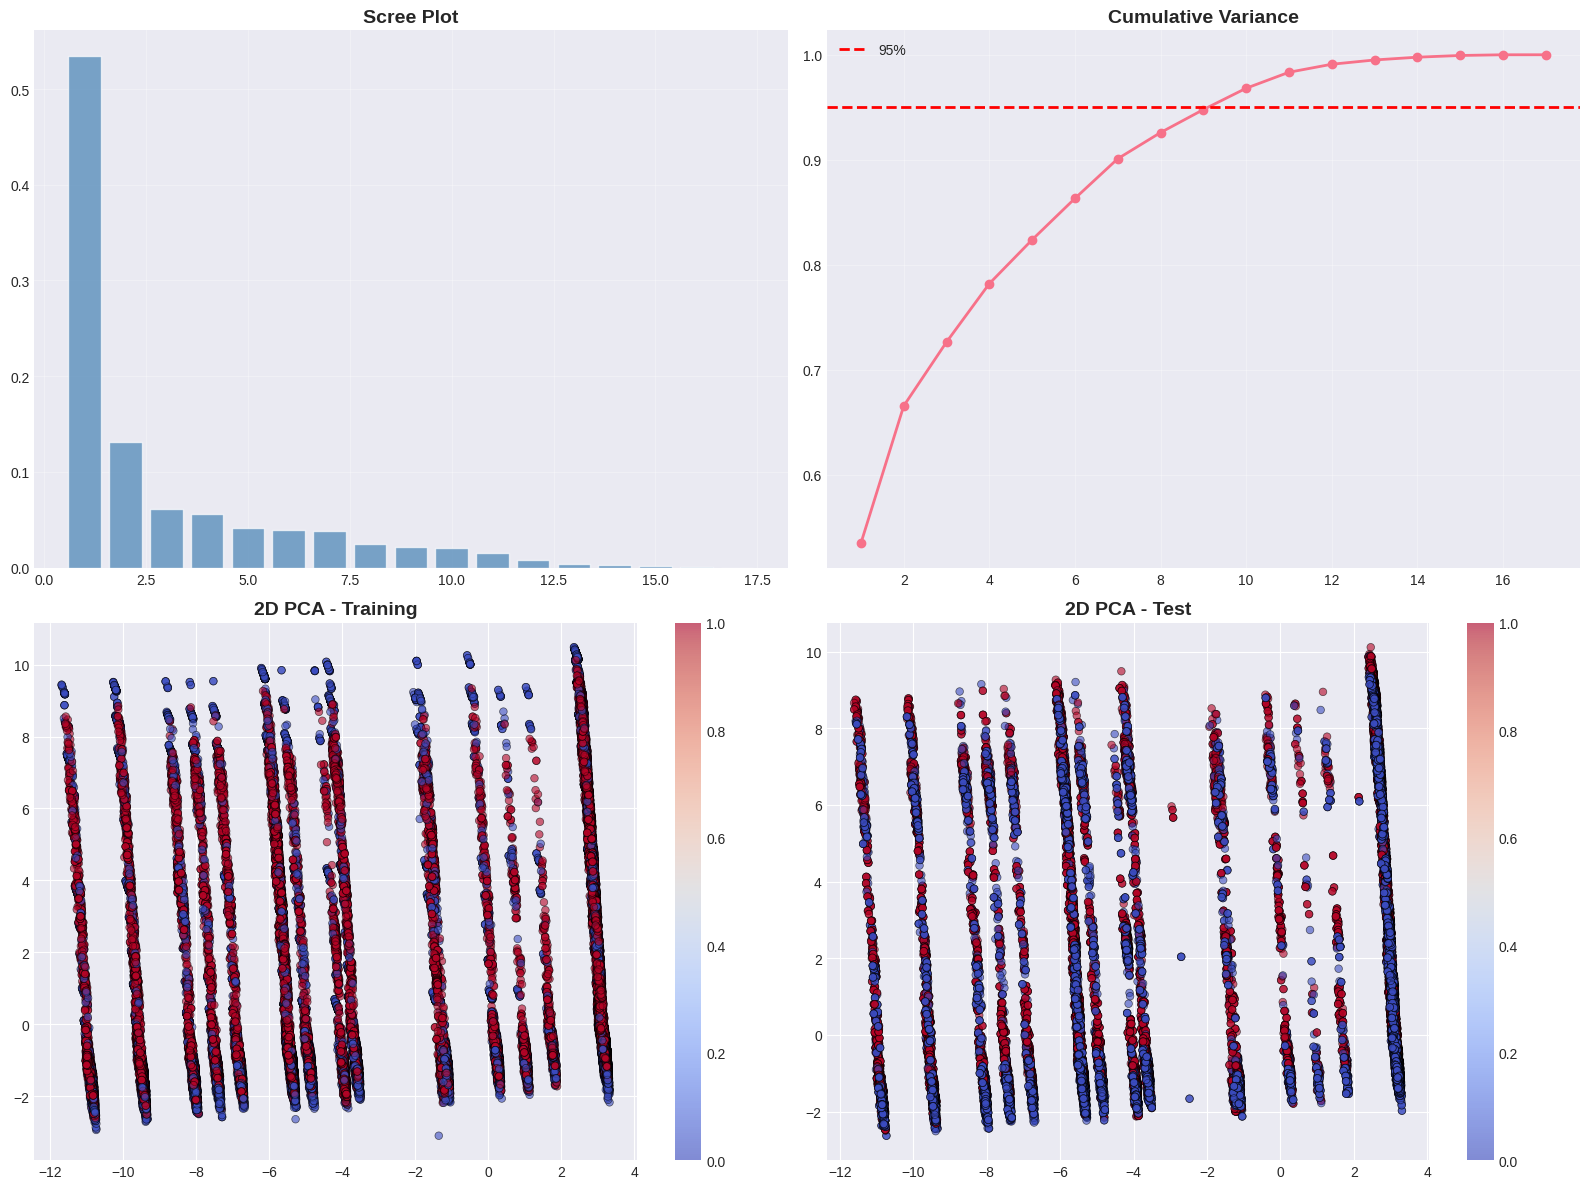

SECTION 6.2: K-MEANS ELBOW ANALYSIS



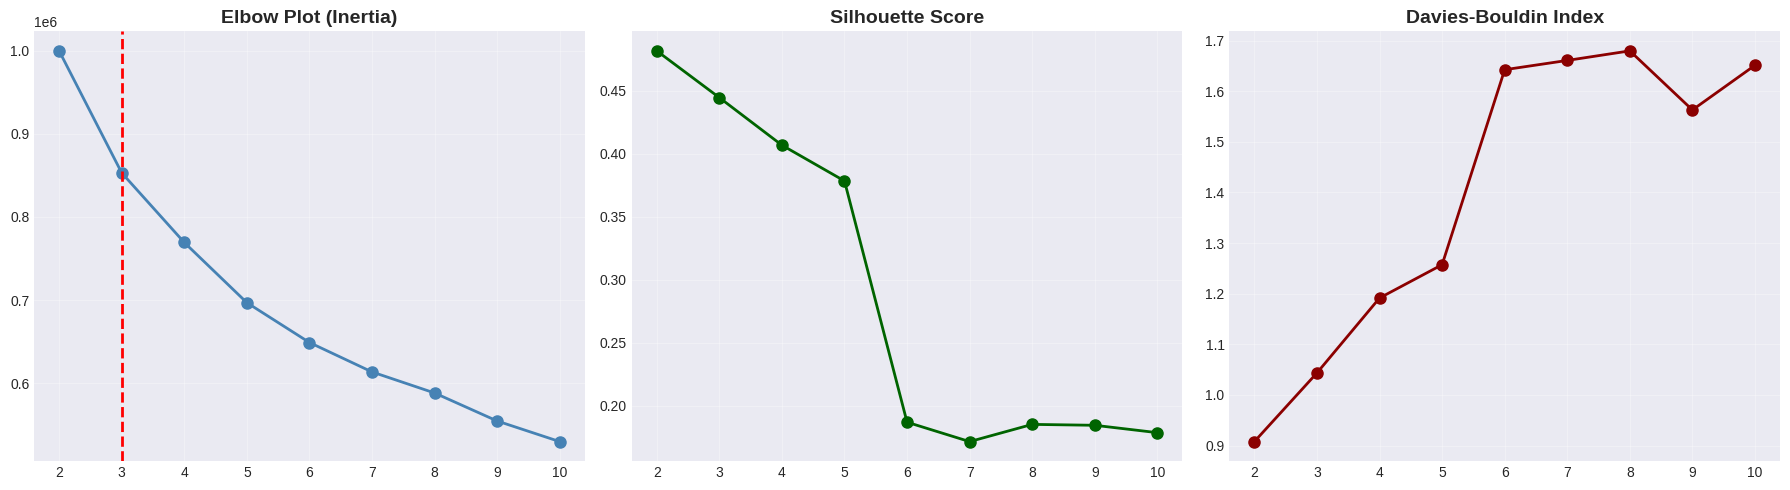

SECTION 6.3: CONFUSION MATRICES



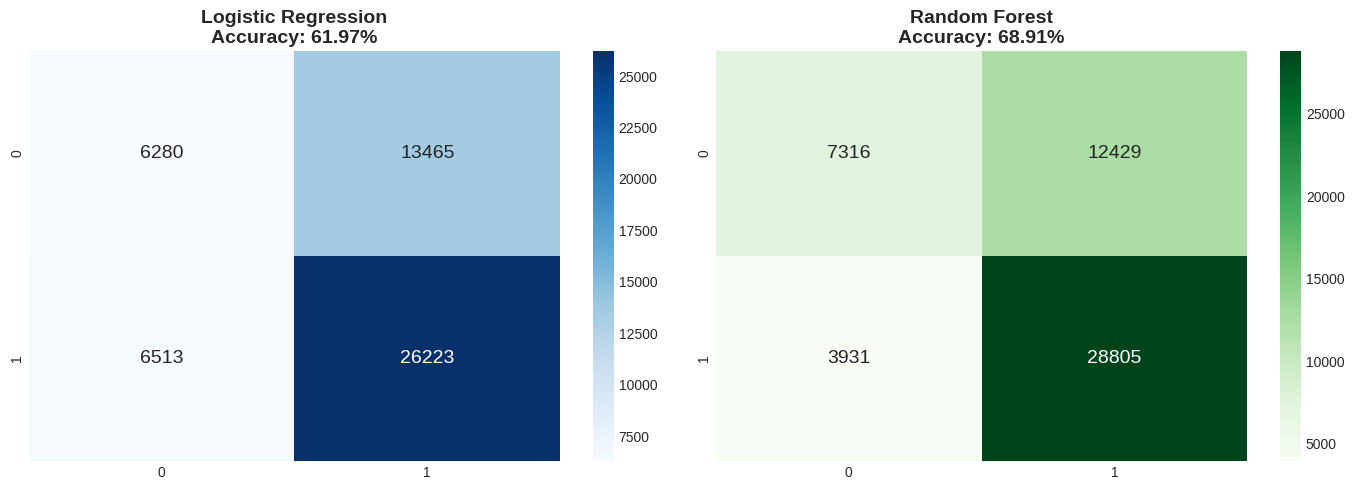

SECTION 6.4: ROC CURVES



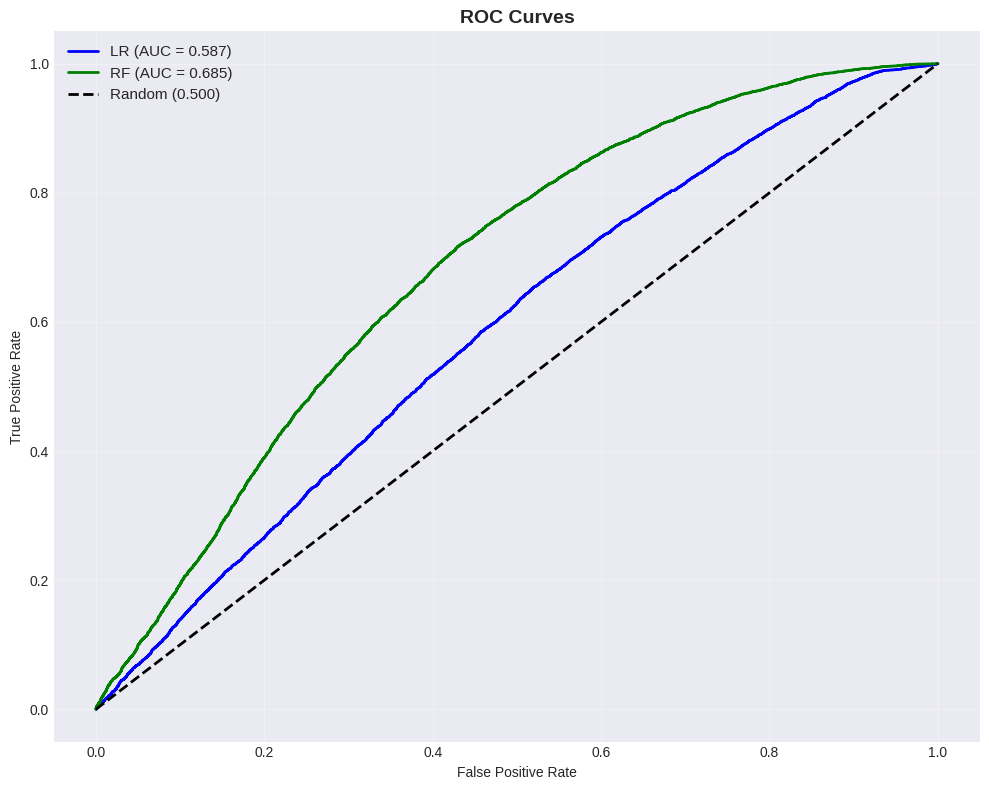

SECTION 6.5: FEATURE IMPORTANCE



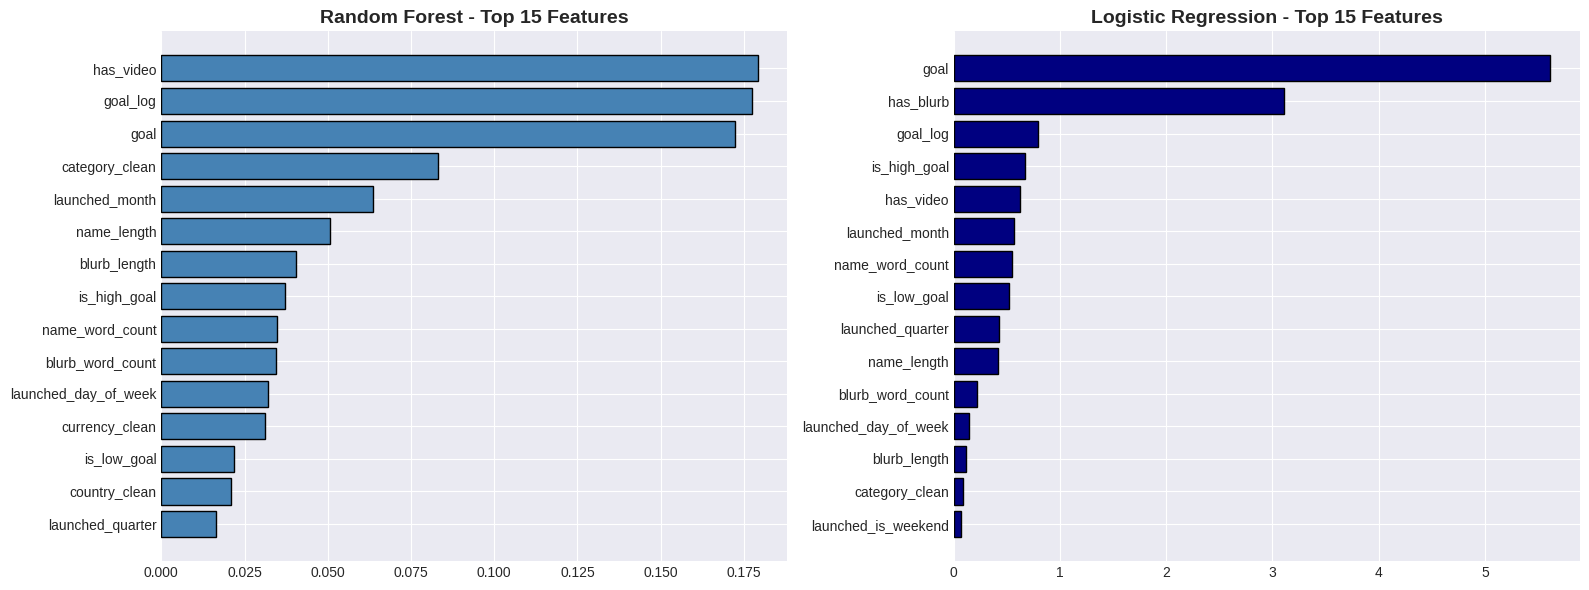

SECTION 6.6: MODEL COMPARISON

✓ Saved: 06_Model_Comparison.png


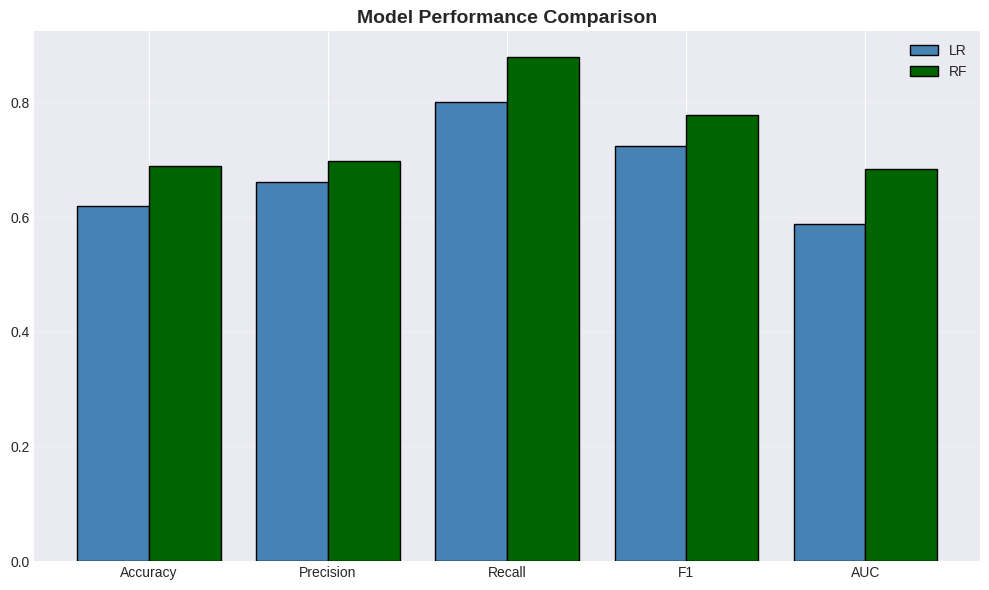

SECTION 6.7: CLUSTERING ANALYSIS

✓ Saved: 07_Clustering.png


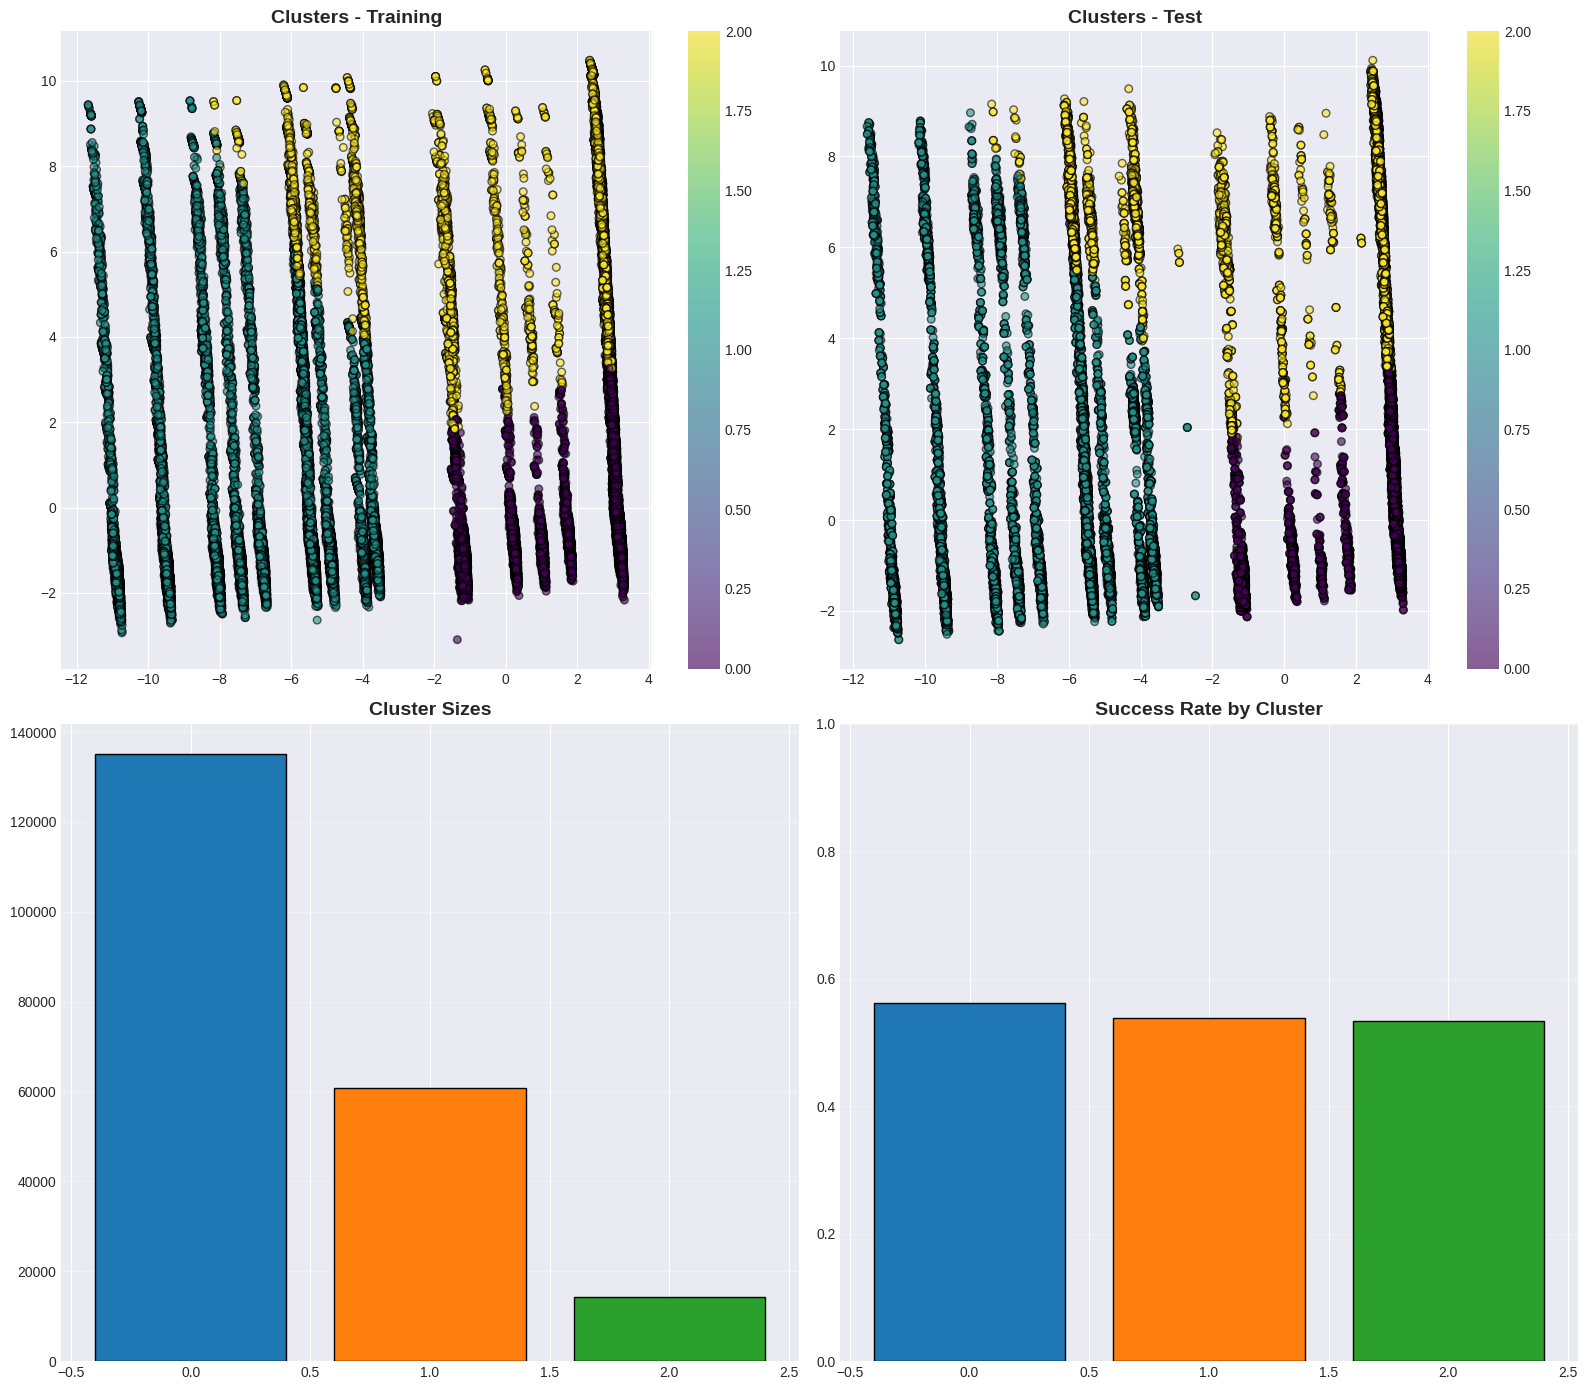

SECTION 6.8: PROBABILITY DISTRIBUTIONS

✓ Saved: 08_Probabilities.png


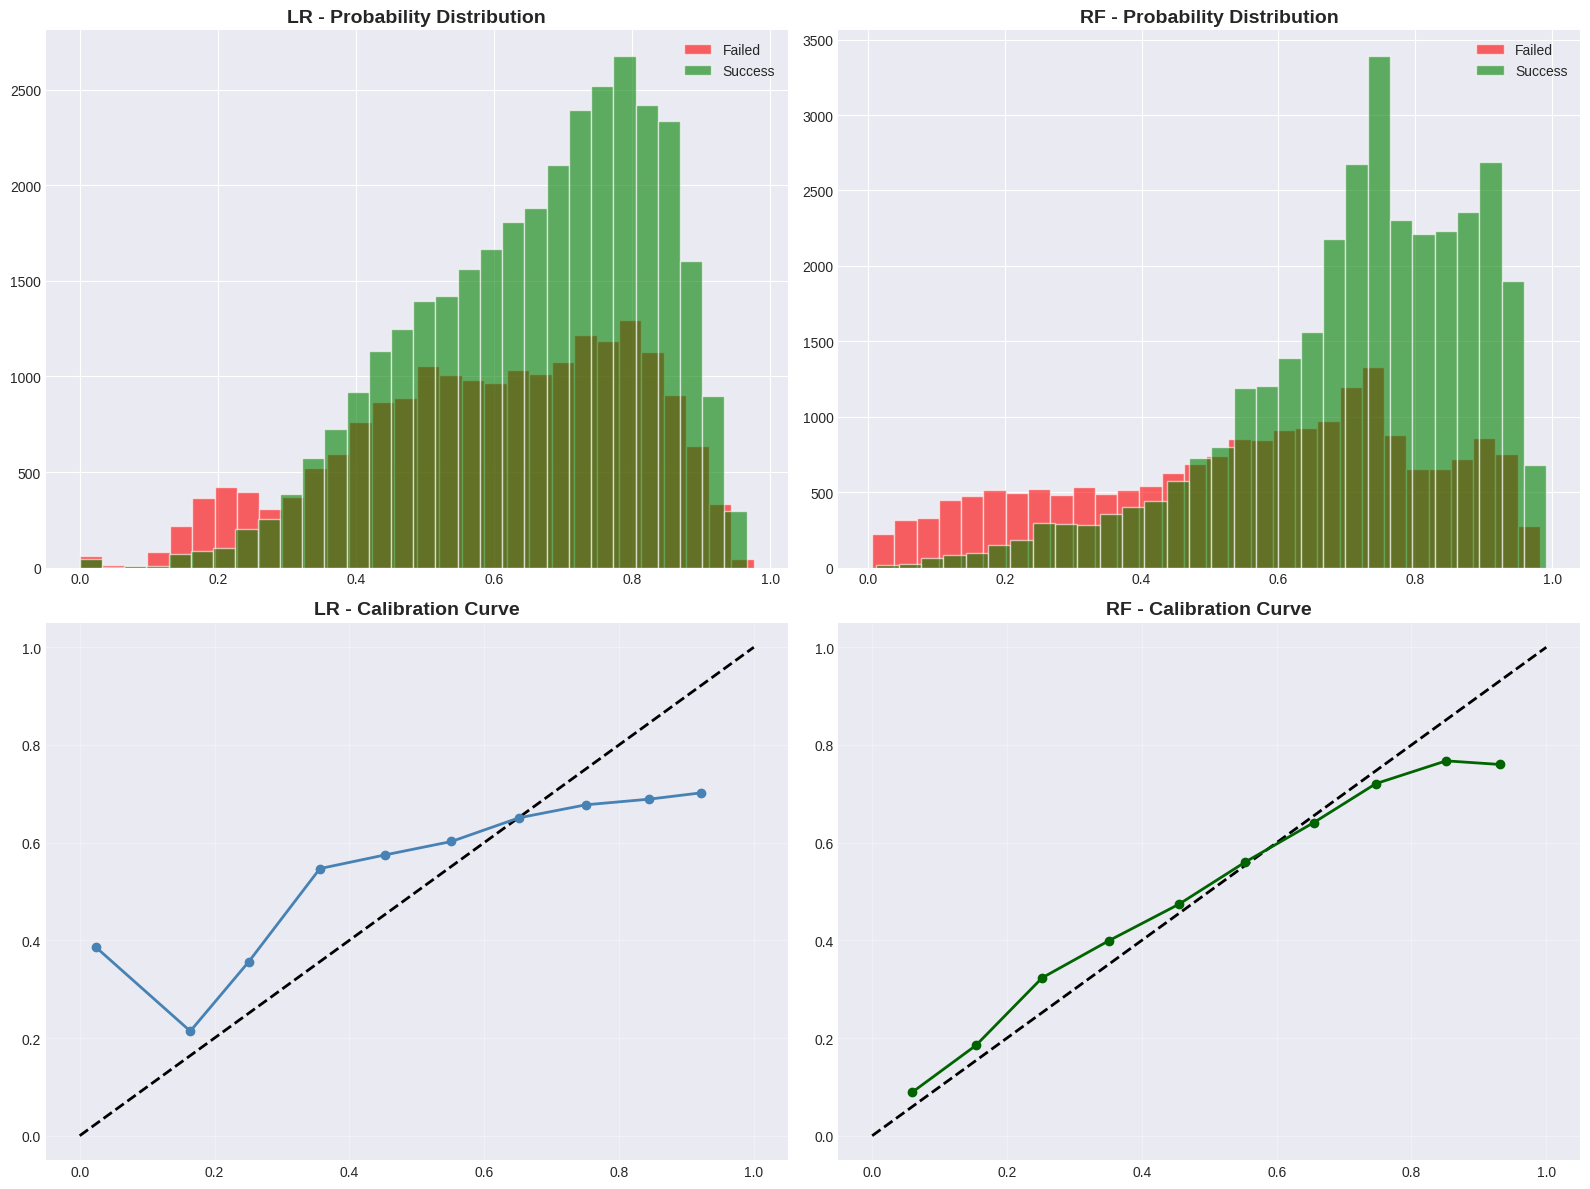

SECTION 6.9: CROSS-VALIDATION ANALYSIS

✓ Saved: 09_CV_Analysis.png


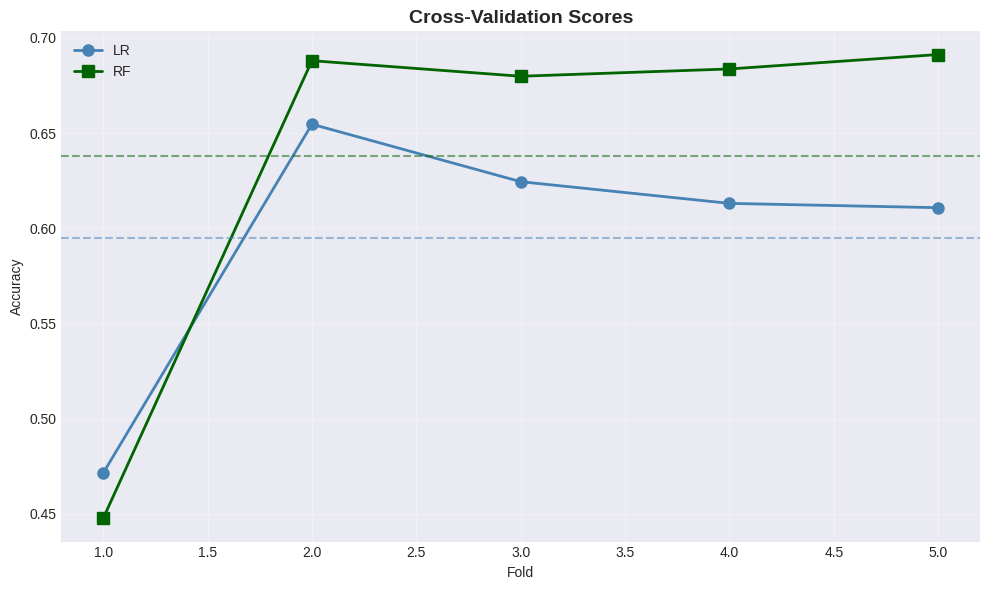


✓ SECTION 6 COMPLETE - 9 VISUALIZATIONS CREATED


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.calibration import calibration_curve # Corrected import
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
import os # Import the os module
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create the output directory if it doesn't exist
output_dir = '/mnt/user-data/outputs/'
os.makedirs(output_dir, exist_ok=True)

print("=" * 80)
print("SECTION 6: COMPREHENSIVE VISUALIZATIONS")
print("=" * 80)
print()

# ============================================================================
# SECTION 6.1: PCA ANALYSIS
# ============================================================================

print("SECTION 6.1: PCA ANALYSIS")
print()

pca = PCA()
X_train_pca = pca.fit_transform(X_train_final)
X_test_pca = pca.transform(X_test_final)
cumsum_var = np.cumsum(pca.explained_variance_ratio_)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scree plot
axes[0, 0].bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_,
               alpha=0.7, color='steelblue')
axes[0, 0].set_title('Scree Plot', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Cumulative variance
axes[0, 1].plot(range(1, len(cumsum_var) + 1), cumsum_var, 'o-', linewidth=2)
axes[0, 1].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95%')
axes[0, 1].set_title('Cumulative Variance', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 2D PCA train
scatter = axes[1, 0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train,
                             cmap='coolwarm', alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[1, 0].set_title('2D PCA - Training', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=axes[1, 0])

# 2D PCA test
scatter2 = axes[1, 1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test,
                              cmap='coolwarm', alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[1, 1].set_title('2D PCA - Test', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1, 1])

plt.tight_layout()

plt.show()

# ============================================================================
# SECTION 6.2: ELBOW PLOT
# ============================================================================

print("SECTION 6.2: K-MEANS ELBOW ANALYSIS")
print()

K_range = range(2, 11)
inertias, silhouette_scores, davies_bouldin_scores = [], [], []

X_sample = X_train_final.sample(n=min(50000, len(X_train_final)), random_state=42)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_sample)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X_sample, kmeans_temp.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X_sample, kmeans_temp.labels_))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(K_range, inertias, 'o-', linewidth=2, markersize=8, color='steelblue')
axes[0].axvline(x=3, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Elbow Plot (Inertia)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'o-', linewidth=2, markersize=8, color='darkgreen')
axes[1].set_title('Silhouette Score', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(K_range, davies_bouldin_scores, 'o-', linewidth=2, markersize=8, color='darkred')
axes[2].set_title('Davies-Bouldin Index', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()


plt.show()

# ============================================================================
# SECTION 6.3: CONFUSION MATRICES
# ============================================================================

print("SECTION 6.3: CONFUSION MATRICES")
print()

y_pred_lr = lr_model.predict(X_test_final)
y_pred_rf = rf_model.predict(X_test_final)

cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0], annot_kws={'fontsize': 14})
axes[0].set_title('Logistic Regression\nAccuracy: 61.97%', fontsize=14, fontweight='bold')

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1], annot_kws={'fontsize': 14})
axes[1].set_title('Random Forest\nAccuracy: 68.91%', fontsize=14, fontweight='bold')

plt.tight_layout()

plt.show()

# ============================================================================
# SECTION 6.4: ROC CURVES
# ============================================================================

print("SECTION 6.4: ROC CURVES")
print()

y_proba_lr = lr_model.predict_proba(X_test_final)[:, 1]
y_proba_rf = rf_model.predict_proba(X_test_final)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr_lr, tpr_lr, 'b-', linewidth=2, label=f'LR (AUC = {roc_auc_lr:.3f})')
ax.plot(fpr_rf, tpr_rf, 'g-', linewidth=2, label=f'RF (AUC = {roc_auc_rf:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (0.500)')
ax.set_title('ROC Curves', fontsize=14, fontweight='bold')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()

# ============================================================================
# SECTION 6.5: FEATURE IMPORTANCE
# ============================================================================

print("SECTION 6.5: FEATURE IMPORTANCE")
print()

rf_imp = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(15)

lr_imp = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Coef': np.abs(lr_model.coef_[0])
}).sort_values('Coef', ascending=True).tail(15)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(rf_imp['Feature'], rf_imp['Importance'], color='steelblue', edgecolor='black')
axes[0].set_title('Random Forest - Top 15 Features', fontsize=14, fontweight='bold')

axes[1].barh(lr_imp['Feature'], lr_imp['Coef'], color='navy', edgecolor='black')
axes[1].set_title('Logistic Regression - Top 15 Features', fontsize=14, fontweight='bold')

plt.tight_layout()

plt.show()

# ============================================================================
# SECTION 6.6: MODEL COMPARISON
# ============================================================================

print("SECTION 6.6: MODEL COMPARISON")
print()

metrics = pd.DataFrame({
    'LR': [test_acc_lr, test_prec_lr, test_rec_lr, test_f1_lr, test_auc_lr],
    'RF': [test_acc_rf, test_prec_rf, test_rec_rf, test_f1_rf, test_auc_rf]
}, index=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metrics.index))
ax.bar(x - 0.2, metrics['LR'], 0.4, label='LR', color='steelblue', edgecolor='black')
ax.bar(x + 0.2, metrics['RF'], 0.4, label='RF', color='darkgreen', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(metrics.index)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

plt.savefig(os.path.join(output_dir, '06_Model_Comparison.png'), dpi=300, bbox_inches='tight')
print("✓ Saved: 06_Model_Comparison.png")
plt.show()

# ============================================================================
# SECTION 6.7: CLUSTERING
# ============================================================================

print("SECTION 6.7: CLUSTERING ANALYSIS")
print()

train_clusters = kmeans_final.predict(X_train_final)
test_clusters = kmeans_final.predict(X_test_final)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

scatter = axes[0, 0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters,
                            cmap='viridis', s=30, alpha=0.6, edgecolors='black')
axes[0, 0].set_title('Clusters - Training', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=axes[0, 0])

scatter2 = axes[0, 1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_clusters,
                             cmap='viridis', s=30, alpha=0.6, edgecolors='black')
axes[0, 1].set_title('Clusters - Test', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[0, 1])

cluster_sizes = pd.Series(train_clusters).value_counts().sort_index()
axes[1, 0].bar(cluster_sizes.index, cluster_sizes.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'],
              edgecolor='black')
axes[1, 0].set_title('Cluster Sizes', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

cluster_success = [y_train[train_clusters == i].mean() for i in range(optimal_k)]
axes[1, 1].bar(range(optimal_k), cluster_success, color=['#1f77b4', '#ff7f0e', '#2ca02c'],
              edgecolor='black')
axes[1, 1].set_title('Success Rate by Cluster', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '07_Clustering.png'), dpi=300, bbox_inches='tight')
print("✓ Saved: 07_Clustering.png")
plt.show()

# ============================================================================
# SECTION 6.8: PROBABILITY DISTRIBUTIONS & CALIBRATION
# ============================================================================

print("SECTION 6.8: PROBABILITY DISTRIBUTIONS")
print()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].hist(y_proba_lr[y_test == 0], bins=30, alpha=0.6, label='Failed', color='red')
axes[0, 0].hist(y_proba_lr[y_test == 1], bins=30, alpha=0.6, label='Success', color='green')
axes[0, 0].set_title('LR - Probability Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()

axes[0, 1].hist(y_proba_rf[y_test == 0], bins=30, alpha=0.6, label='Failed', color='red')
axes[0, 1].hist(y_proba_rf[y_test == 1], bins=30, alpha=0.6, label='Success', color='green')
axes[0, 1].set_title('RF - Probability Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend()

prob_true_lr, prob_pred_lr = calibration_curve(y_test, y_proba_lr, n_bins=10)
axes[1, 0].plot([0, 1], [0, 1], 'k--', linewidth=2)
axes[1, 0].plot(prob_pred_lr, prob_true_lr, 'o-', linewidth=2, color='steelblue')
axes[1, 0].set_title('LR - Calibration Curve', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

prob_true_rf, prob_pred_rf = calibration_curve(y_test, y_proba_rf, n_bins=10)
axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=2)
axes[1, 1].plot(prob_pred_rf, prob_true_rf, 'o-', linewidth=2, color='darkgreen')
axes[1, 1].set_title('RF - Calibration Curve', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '08_Probabilities.png'), dpi=300, bbox_inches='tight')
print("✓ Saved: 08_Probabilities.png")
plt.show()

# ============================================================================
# SECTION 6.9: CROSS-VALIDATION
# ============================================================================

print("SECTION 6.9: CROSS-VALIDATION ANALYSIS")
print()

fig, ax = plt.subplots(figsize=(10, 6))
folds = range(1, 6)
ax.plot(folds, cv_scores_lr, 'o-', linewidth=2, markersize=8, label='LR', color='steelblue')
ax.plot(folds, cv_scores_rf, 's-', linewidth=2, markersize=8, label='RF', color='darkgreen')
ax.axhline(y=cv_scores_lr.mean(), color='steelblue', linestyle='--', alpha=0.5)
ax.axhline(y=cv_scores_rf.mean(), color='darkgreen', linestyle='--', alpha=0.5)
ax.set_title('Cross-Validation Scores', fontsize=14, fontweight='bold')
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

plt.savefig(os.path.join(output_dir, '09_CV_Analysis.png'), dpi=300, bbox_inches='tight')
print("✓ Saved: 09_CV_Analysis.png")
plt.show()

print()
print("=" * 80)
print("✓ SECTION 6 COMPLETE - 9 VISUALIZATIONS CREATED")
print("=" * 80)